In [22]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

IMG_HEIGHT, IMG_WIDTH = 256, 256
NUM_CLASSES = 3
BATCH_SIZE = 8
BUFFER_SIZE = 100
EPOCHS = 30

IMAGE_DIR = '/Users/salah/Desktop/intern/pipe_segmentation/images'
MASK_DIR = '/Users/salah/Desktop/intern/pipe_segmentation/generated_segmentation_masks'


In [23]:
def preprocess_mask(mask):
    # Map pixel values to class IDs:
    # Assuming mask pixel values: 0=background, 127=outer edge, 255=inner edge
    mask = np.where(mask == 127, 1, mask)
    mask = np.where(mask == 255, 2, mask)
    mask = np.where(mask < 1, 0, mask)
    return mask.astype(np.uint8)

# Load images and masks matching by filename
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.png')])

image_dict = {os.path.splitext(f)[0]: f for f in image_files}
mask_dict = {os.path.splitext(f)[0].replace('_processed_annotated_mask',''): f for f in mask_files}

X, Y = [], []

for base_name, img_file in image_dict.items():
    if base_name in mask_dict:
        img_path = os.path.join(IMAGE_DIR, img_file)
        mask_path = os.path.join(MASK_DIR, mask_dict[base_name])

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        mask = preprocess_mask(mask)

        X.append(img)
        Y.append(mask)

X = np.array(X)
Y = np.array(Y)

# One-hot encode masks (needed for categorical crossentropy)
Y = tf.keras.utils.to_categorical(Y, num_classes=NUM_CLASSES)

print(f"Loaded {len(X)} image-mask pairs")
print(f"Image shape: {X.shape}, Mask shape: {Y.shape}")


Loaded 77 image-mask pairs
Image shape: (77, 256, 256, 3), Mask shape: (77, 256, 256, 3)


In [24]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=42)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Train samples: 55
Validation samples: 14
Test samples: 8


In [25]:
# Convert one-hot encoded masks to class ID labels
Y_train_labels = np.argmax(Y_train, axis=-1).astype(np.uint8)

all_pixels = Y_train_labels.flatten()
pixel_counts = Counter(all_pixels)
total_pixels = len(all_pixels)

print("\n📊 Pixel Class Distribution in Training Masks:")
for class_id in range(NUM_CLASSES):
    count = pixel_counts[class_id]
    percent = (count / total_pixels) * 100
    print(f"Class {class_id}: {count} pixels ({percent:.2f}%)")

# Calculate class weights inversely proportional to frequency
class_weights = {}
for cls, count in pixel_counts.items():
    class_weights[cls] = total_pixels / (NUM_CLASSES * count)

print("\nClass weights (before clipping):")
print(class_weights)

# Clip max weights to avoid extreme values harming training
max_weight = 20.0
clipped_weights = {k: min(v, max_weight) for k, v in class_weights.items()}

print("\nClass weights (after clipping):")
print(clipped_weights)



📊 Pixel Class Distribution in Training Masks:
Class 0: 3581764 pixels (99.37%)
Class 1: 11726 pixels (0.33%)
Class 2: 10990 pixels (0.30%)

Class weights (before clipping):
{np.uint8(0): 0.335447375464529, np.uint8(1): 102.46404002501563, np.uint8(2): 109.32605398847437}

Class weights (after clipping):
{np.uint8(0): 0.335447375464529, np.uint8(1): 20.0, np.uint8(2): 20.0}


In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [27]:
weights_list = [clipped_weights[i] for i in range(NUM_CLASSES)]
weights_tensor = tf.constant(weights_list, dtype=tf.float32)

def weighted_categorical_crossentropy(y_true, y_pred):
    # Ensure y_true and y_pred are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weights_per_pixel = tf.reduce_sum(weights_tensor * y_true, axis=-1)
    weighted_loss = cce * weights_per_pixel
    return tf.reduce_mean(weighted_loss)


In [28]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = tf.reshape(y_true, [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, NUM_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice = tf.reduce_mean((2. * intersection + smooth) / (denominator + smooth))
    return dice


In [29]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)
    
    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)
    
    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)
    
    # Bottleneck
    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)
    
    # Decoder
    u5 = UpSampling2D()(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)
    
    u6 = UpSampling2D()(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D()(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)
    
    outputs = Conv2D(num_classes, 1, activation='softmax')(c7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model()
model.compile(optimizer=Adam(1e-4),
              loss=weighted_categorical_crossentropy,
              metrics=[dice_coef])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 192)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    110,656 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_24[0][0] 

 Total params: 487,331 (1.86 MB)

 Trainable params: 487,331 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)


Epoch 1/30


2025-07-27 20:34:54.891169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - dice_coef: 0.0057 - loss: 6.4651 - val_dice_coef: 0.0825 - val_loss: 1.4293
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - dice_coef: 0.2182 - loss: 0.9041 - val_dice_coef: 0.3277 - val_loss: 0.4774
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - dice_coef: 0.3201 - loss: 0.5162 - val_dice_coef: 0.3234 - val_loss: 0.5096
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - dice_coef: 0.3285 - loss: 0.5485 - val_dice_coef: 0.3307 - val_loss: 0.4039
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - dice_coef: 0.3317 - loss: 0.4238 - val_dice_coef: 0.3233 - val_loss: 0.3154
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - dice_coef: 0.3226 - loss: 0.3521 - val_dice_coef: 0.3206 - val_loss: 0.2854
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - dice_coef: 0.3218 - loss: 0.3166 - val_dice_coef: 0.3193 - val_loss: 0.2459
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - dice_coef: 0.3258 - loss: 0.2480 - val_dice_coef: 0.3117 - val_loss: 0.2334
Epoch 9/30

In [31]:
test_loss, test_dice = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - dice_coef: 0.3857 - loss: 0.1080
Test Loss: 0.1080, Test Dice Coefficient: 0.3857


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


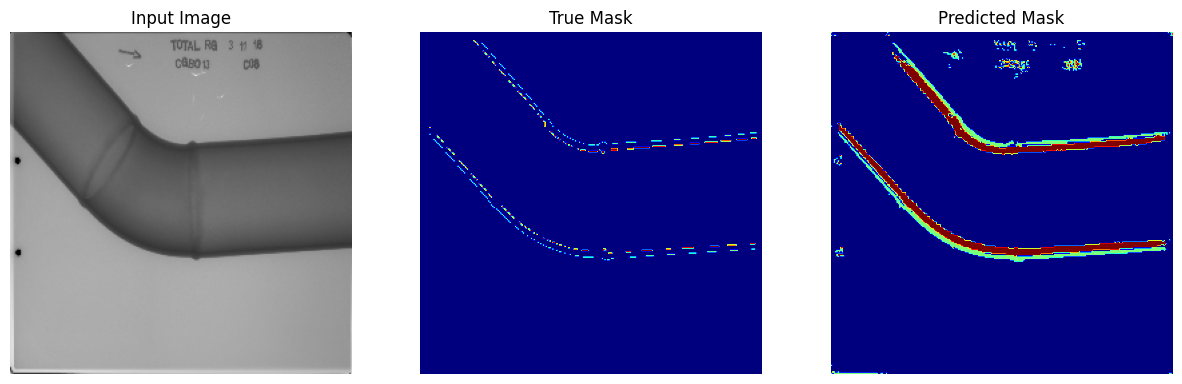

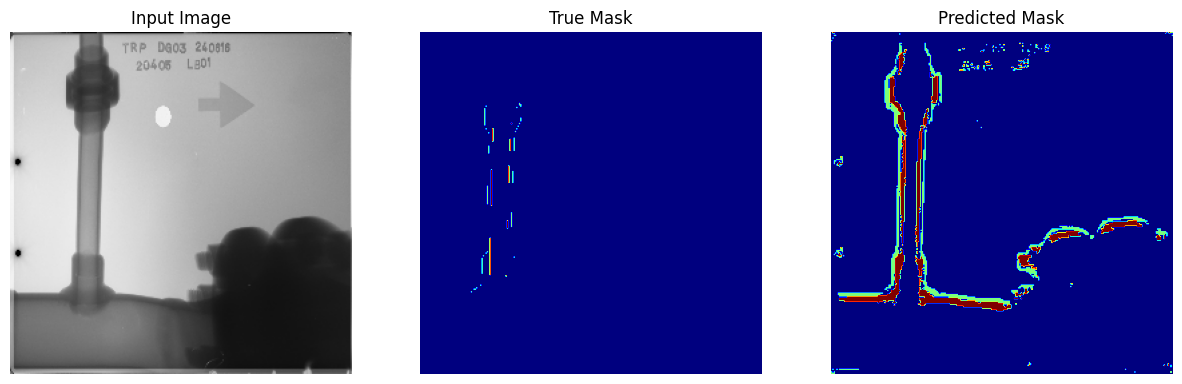

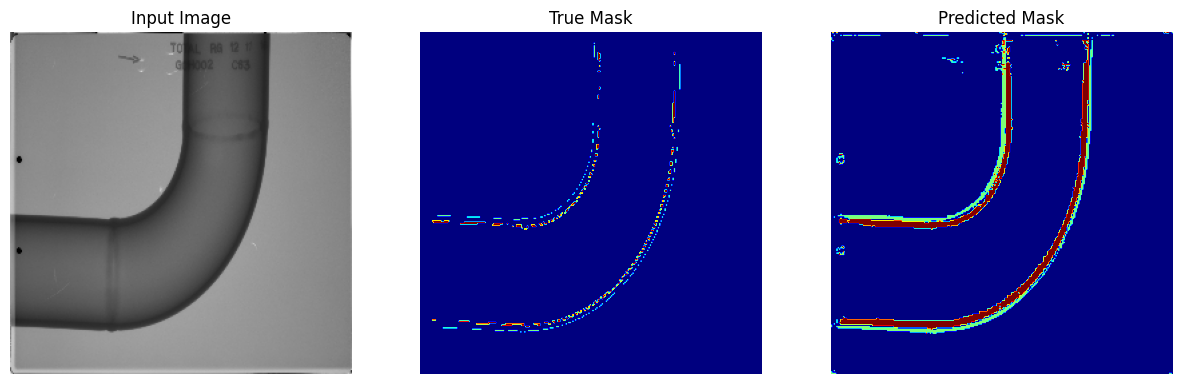

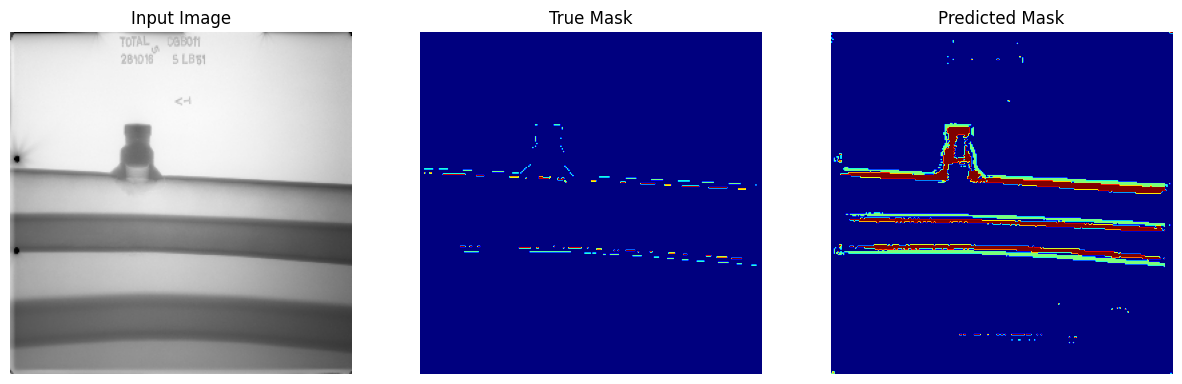

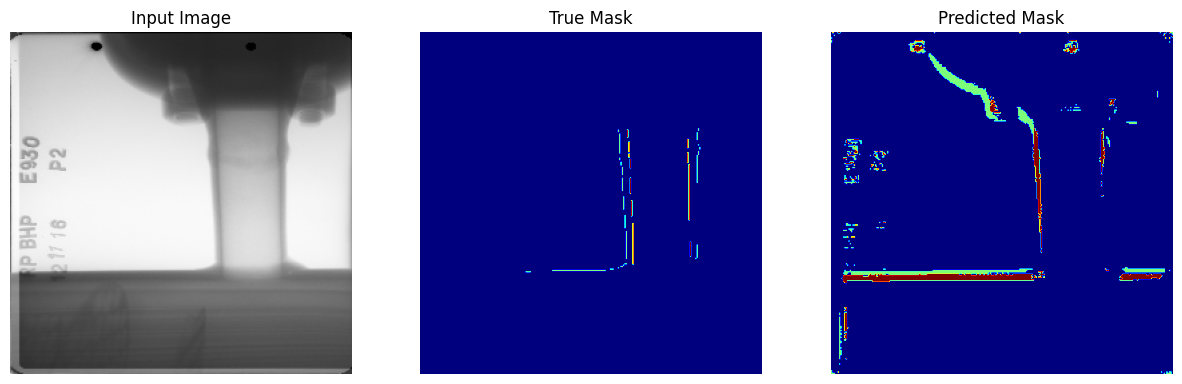

2025-07-27 20:41:17.674823: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num=5):
    # Take a batch from the dataset
    for images, true_masks in dataset.take(1):
        preds = model.predict(images)
        preds = np.argmax(preds, axis=-1)
        true_masks = np.argmax(true_masks.numpy(), axis=-1)
        images = images.numpy()

        for i in range(num):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(images[i].astype(np.uint8))
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            axes[1].imshow(true_masks[i], cmap='jet', vmin=0, vmax=2)
            axes[1].set_title("True Mask")
            axes[1].axis('off')

            axes[2].imshow(preds[i], cmap='jet', vmin=0, vmax=2)
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            plt.show()

# Call this function with your model and test dataset
visualize_predictions(model, test_ds, num=5)
